# Simple Example of ParameterWithSetpoints
This notebook has an example of a new simpler ArrayParameter replacement


In [1]:
import numpy as np

In [2]:
from qcodes.utils.validators import Validator

In [3]:
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.dataset.measurements import Measurement

In [4]:
from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import new_experiment

In [5]:
from qcodes.instrument.parameter import ParameterWithSetpoints, GeneratedSetPoints

Here we define an dummy instrument that returns something like a frequency spectrum from `f_start` to `f_stop`
in `n_points` steps. The functionality of the ArrayParameter is implemented only by having a reference to it's setpoints which is consumed by the dataset context manager. To do this we only have to define the parameter for the setpoints and the spectrum and let the parameter know that the frequency axis is the setpoints 

In [6]:
class DummyArray(ParameterWithSetpoints):
    
    def get_raw(self):
        npoints = self.root_instrument.n_points()
        return np.random.rand(npoints)
    

class DummySpectrumAnalyzer(Instrument):
    
    def __init__(self, name, **kwargs):
        
        super().__init__(name, **kwargs)
            

        self.add_parameter('f_start',
                           initial_value=0,
                           unit='Hz',
                           label='f start',
                           vals=Numbers(0,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('f_stop',
                           unit='Hz',
                           label='f stop',
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('n_points',
                           unit='',
                           initial_value=10,
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter('freq_axis',
                           unit='Hz',
                           label='Freq Axis',
                           parameter_class=GeneratedSetPoints,
                           startparam=self.f_start,
                           stopparam=self.f_stop,
                           numpointsparam=self.n_points,
                           vals=Arrays(shape=(self.n_points,)))
                           
        self.add_parameter('spectrum',
                   unit='dBm',
                   setpoints=(self.freq_axis,),
                   label='Spectrum',
                   parameter_class=DummyArray,
                   vals=Arrays(shape=(self.n_points,)))
                

In [7]:
initialise_database()
new_experiment(name='tutorial_exp', sample_name="no sample")

tutorial_exp#no sample#63@C:\Users\jenielse/experiments.db
----------------------------------------------------------

In [8]:
a = DummySpectrumAnalyzer('foobar')

First we setup the limits of the spectrum

In [9]:
a.f_start(0)
a.f_stop(500)
a.n_points(501)

And we can grab the axis

In [10]:
a.freq_axis()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

Or the spectrum

In [11]:
a.spectrum.validate(a.spectrum.get())

In [12]:
a.spectrum.get()

array([7.09353668e-01, 9.62526695e-01, 2.05186526e-01, 2.94036210e-01,
       5.06606897e-01, 8.29893568e-02, 3.33735907e-01, 4.42400625e-01,
       9.16681461e-02, 5.81358311e-01, 4.51932652e-01, 1.87074773e-01,
       2.02380668e-01, 6.53316860e-01, 1.72141579e-01, 1.86279204e-02,
       9.64464161e-01, 9.49980096e-01, 2.18509360e-01, 8.73908097e-01,
       6.95477171e-01, 8.45280249e-02, 9.88475564e-01, 7.48583006e-01,
       3.75698256e-01, 6.63416424e-01, 4.45721082e-02, 2.01031788e-02,
       9.11969530e-01, 3.18978737e-01, 4.55256870e-02, 7.69627991e-02,
       6.15589717e-01, 8.30054206e-01, 9.85316349e-01, 1.99833448e-03,
       8.13712260e-01, 9.19068159e-01, 3.33893582e-01, 3.88520350e-02,
       1.83501588e-01, 5.81598202e-02, 8.79058536e-01, 2.77580615e-01,
       3.98459361e-01, 7.45159171e-01, 7.02160997e-01, 5.60560683e-02,
       5.76319201e-02, 9.78713128e-01, 4.29086064e-01, 7.81239698e-01,
       6.19173707e-01, 4.12860279e-01, 8.23556372e-01, 7.49529829e-01,
      

We can also directly consume the parameter in a measurement

In [13]:
meas = Measurement()
meas.register_parameter(a.spectrum)  # register the first independent parameter

with meas.run() as datasaver:
    datasaver.add_result((a.spectrum, a.spectrum.get(),))
    
    dataid = datasaver.run_id  # convenient to have for plotting

Starting experimental run with id: 194


In [14]:
from qcodes.dataset.plotting import plot_by_id

And plot it

([<matplotlib.axes._subplots.AxesSubplot at 0x1a94560a080>], [None])

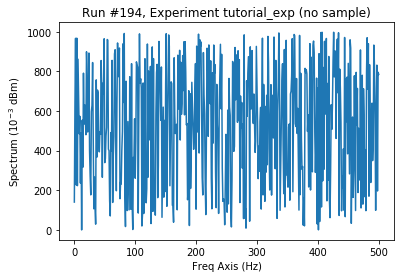

In [15]:
plot_by_id(dataid)